<a href="https://colab.research.google.com/github/stayxyz/CreditAnalytics/blob/master/Formal_Copy_of_LGD_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part III Constructing LGD Using Random Forest Tree & XGBoosting 

In [ ]:
import pandas as pd

In [ ]:
!gdown https://drive.google.com/uc?id=1zdZXOrj7_2li4LNZTbgMW7d12k0YqUao

Downloading...
From: https://drive.google.com/uc?id=1zdZXOrj7_2li4LNZTbgMW7d12k0YqUao
To: /content/LGD_data2.csv
47.0MB [00:00, 219MB/s]


In [ ]:
LGD_data = pd.read_csv('LGD_data2.csv')

In [ ]:
LGD_data.head()

,loan_amnt,term,emp_length,home_ownership,annual_inc,loan_status,purpose,zip_code,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_record,total_acc,out_prncp,total_pymnt,total_rec_int,last_credit_pull_d,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_act_il,open_il_24m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_op_rev_tl,num_tl_120dpd_2m,num_tl_90g_dpd_24m,num_tl_op_past_12m,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bc_limit,total_il_high_credit_limit,hardship_flag,hardship_amount,debt_settlement_flag,LGD
0,18000.0,60 months,7,RENT,150000.0,1,debt_consolidation,9,9.39,0.0,2005.0,1.0,75.0,27.0,0.0,9452.74,4351.98,2017.0,580.0,0.0,-1.0,Individual,0.0,60.0,36247.0,2.0,3.0,4.0,1271.0,55.0,34500.0,2.0,1.0,0.0,0.0,112.0,1.0,2.0,2.0,-1.0,0.0,6.0,16.0,0.0,0.0,3.0,14.3,1.0,0.0,65819.0,10300.0,31319.0,N,0.0,N,0.908563
1,16000.0,36 months,10,MORTGAGE,65000.0,1,small_business,3,18.96,0.0,1985.0,0.0,66.0,20.0,0.0,17396.63,3402.05,2019.0,625.0,0.0,55.0,Individual,0.0,1830.0,39781.0,2.0,0.0,2.0,739.0,64.0,9500.0,0.0,5.0,0.0,0.0,360.0,1.0,0.0,14.0,33.0,1.0,3.0,5.0,0.0,0.0,2.0,0.0,0.0,1.0,80999.0,4700.0,71499.0,N,0.0,N,0.925487
2,10000.0,60 months,2,MORTGAGE,55000.0,1,credit_card,8,35.70,0.0,2001.0,0.0,-1.0,28.0,0.0,5558.20,2871.05,2018.0,520.0,0.0,-1.0,Individual,0.0,0.0,288087.0,2.0,2.0,1.0,6742.0,85.0,49500.0,0.0,3.0,0.0,0.0,176.0,7.0,6.0,6.0,-1.0,0.0,3.0,11.0,0.0,0.0,4.0,100.0,0.0,0.0,302401.0,11000.0,34953.0,N,0.0,N,1.000000
3,35000.0,60 months,7,MORTGAGE,106000.0,1,debt_consolidation,3,17.36,0.0,2002.0,0.0,-1.0,27.0,0.0,22968.61,7086.13,2019.0,500.0,0.0,-1.0,Individual,0.0,0.0,299890.0,3.0,0.0,0.0,9701.0,60.0,54200.0,0.0,4.0,0.0,0.0,164.0,38.0,4.0,-1.0,-1.0,0.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,366974.0,39200.0,36981.0,N,0.0,N,0.815285
4,14000.0,60 months,2,MORTGAGE,60000.0,1,debt_consolidation,8,24.29,0.0,2009.0,0.0,-1.0,24.0,0.0,7458.90,2770.73,2017.0,510.0,0.0,-1.0,Individual,0.0,0.0,70789.0,2.0,2.0,1.0,4952.0,89.0,17200.0,1.0,0.0,0.0,0.0,71.0,23.0,0.0,0.0,-1.0,0.0,7.0,9.0,0.0,0.0,1.0,87.5,0.0,0.0,83083.0,15100.0,65883.0,N,0.0,N,0.885144


Since we already know LGD only works with "defaulted" loans, so we can drop 'loan_status' indicator

In [ ]:
LGD_data = LGD_data.drop(['loan_status'], axis = 1)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
LGD_data.shape

(150684, 55)

Since prime driver of LGD in the this Loan Club is credit worthiness, salary,  time at job, EAD, and geographic information.


The credit worthiness variable: we will use credit score card's variable.

salary: annual income

time at job: employ length 

Partial Information fo EAD: total payment and debt settlement flag 

geographic information: first letter of zip code

In [ ]:
LGD_Variables = ['last_fico_range_low',
 'last_credit_pull_d',
 'total_pymnt',
 'all_util',
 'open_il_24m',
 'max_bal_bc',
 'open_act_il',
 'total_cu_tl',
 'LGD',
 'emp_length',
 'home_ownership',
 'zip_code',
 'annual_inc']

In [ ]:
LGD_data = LGD_data[LGD_Variables]

In [ ]:
object_columns_df = LGD_data.select_dtypes(include=['object'])
print(object_columns_df.iloc[0])

debt_settlement_flag       N
home_ownership          RENT
Name: 0, dtype: object


In [ ]:
LGD_data = pd.get_dummies(LGD_data)

In [ ]:
LGD_data.isnull().sum()

last_fico_range_low        0
last_credit_pull_d         0
total_pymnt                0
all_util                   0
open_il_24m                0
max_bal_bc                 0
open_act_il                0
total_cu_tl                0
LGD                        0
emp_length                 0
zip_code                   0
annual_inc                 0
debt_settlement_flag_N     0
debt_settlement_flag_Y     0
home_ownership_MORTGAGE    0
home_ownership_OWN         0
home_ownership_RENT        0
dtype: int64

Now we calibrate optimal parameter for random forest 

In [ ]:
LGD_data.shape

(150684, 17)

## Build Random Forest Model for LGD

### Cross Validation to choose the optimal paramters for Random Forest

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
!pip install scorecardpy
import scorecardpy as sc


In [ ]:
LGDtrain, LGDtest = sc.split_df(LGD_data, ratio = 0.66, seed = 251121253).values()

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 500, stop = 10000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 500, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8, 16]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap }

In [ ]:
rf = RandomForestRegressor()

In [ ]:
LGD_random = RandomizedSearchCV(estimator = rf, 
                                param_distributions = random_grid, 
                                n_iter = 10, 
                                cv = 10, verbose=1, random_state=251121253
                                , n_jobs = -1)

In [ ]:
sample = LGDtrain.sample(frac = 0.01)

In [ ]:
LGD_random.fit((sample.iloc[:,sample.columns != 'LGD']), sample['LGD'])

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 15.7min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_st...


In [ ]:
LGD_random.best_params_

{'bootstrap': False,
 'max_depth': 500,
 'max_features': 'sqrt',
 'min_samples_leaf': 8,
 'min_samples_split': 2,
 'n_estimators': 500}

In [ ]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [400, 500, 600],
    'max_features': ['auto','sqrt'],
    'min_samples_leaf': [4, 8, 16],
    'min_samples_split': [2, 4, 8],
    'n_estimators': [500, 1000, 2000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 10, n_jobs = -1, verbose = 1)

In [ ]:
grid_search.fit((sample.iloc[:,sample.columns != 'LGD']), sample['LGD'])

Fitting 10 folds for each of 162 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 27.6min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 51.5min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 74.2min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed: 88.2min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_depth

In [ ]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': 600,
 'max_features': 'sqrt',
 'min_samples_leaf': 8,
 'min_samples_split': 4,
 'n_estimators': 500}

From the randomCV and Grid-search: we have the following conclusion about the optimal hyperparameters: 

{'bootstrap': False, \\
 'max_depth': 600, (may be the more the better) \\
 'max_features': 'sqrt', \\
 'min_samples_leaf': 8, \\
 'min_samples_split': 4, \\
 'n_estimators': 500 (may be the more the better}  \\

### Build LGD Model using RandomForest Regressor 

We apply the optimal parameters, since sample is 1% of the training data, we multiply the number of estimator by 10.

In [ ]:
LGD_rf = RandomForestRegressor(n_estimators=5000, # Number of trees to train
                       criterion='mse', # How to train the trees. Also supports entropy.
                       max_depth= 600, # Max depth of the trees. Not necessary to change.
                       min_samples_split= 4, # Minimum samples to create a split.
                       min_samples_leaf= 8, # Minimum samples in a leaf. Accepts fractions for %. This is 0.1% of sample.
                       min_weight_fraction_leaf= 0.0, # Same as above, but uses the class weights.
                       max_features='sqrt', # Maximum number of features per split (not tree!) by default is sqrt(vars)
                       max_leaf_nodes=None, # Maximum number of nodes.
                       min_impurity_decrease=0.0001, # Minimum impurity decrease. This is 10^-3.
                       bootstrap=False, # If sample with repetition. For large samples (>100.000) set to false.
                       oob_score=False,  # If report accuracy with non-selected cases.
                       n_jobs=2, # Parallel processing. Set to -1 for all cores. Watch your RAM!!
                       random_state=251121253, # Seed
                       verbose=1, # If to give info during training. Set to 0 for silent training.
                       warm_start=False, # If train over previously trained tree.
                                    )

In [ ]:
LGD_rf.fit(LGDtrain.iloc[:,LGDtrain.columns != 'LGD'], LGDtrain['LGD'])

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    3.4s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    7.7s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:   13.4s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:   20.8s
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:   30.0s
[Parallel(n_jobs=2)]: Done 2446 tasks      | elapsed:   41.0s
[Parallel(n_jobs=2)]: Done 3196 tasks      | elapsed:   53.5s
[Parallel(n_jobs=2)]: Done 4046 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done 4996 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done 5000 out of 5000 | elapsed:  1.4min finished


RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=600,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0001, min_impurity_split=None,
                      min_samples_leaf=8, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, n_estimators=5000, n_jobs=2,
                      oob_score=False, random_state=251121253, verbose=1,
                      warm_start=False)

In [ ]:
print(LGD_rf.feature_importances_)

[0.01359394 0.20079044 0.01009458 0.01796233 0.04328685 0.03837624
 0.03768913 0.03727804 0.         0.         0.         0.27278557
 0.32814288 0.         0.         0.        ]


In [ ]:
R2 = LGD_rf.score(LGDtest.iloc[:,LGDtest.columns != 'LGD'], LGDtest['LGD'])

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done 2446 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done 3196 tasks      | elapsed:    1.5s
[Parallel(n_jobs=2)]: Done 4046 tasks      | elapsed:    1.9s
[Parallel(n_jobs=2)]: Done 4996 tasks      | elapsed:    2.3s
[Parallel(n_jobs=2)]: Done 5000 out of 5000 | elapsed:    2.3s finished


In [ ]:
n = LGDtest.shape[0] 
p = len(LGD_Variables)
Adj_r2 = 1-(1-R2)*(n-1)/(n-p-1)
print(R2)
print(Adj_r2)

0.2929827747483723
0.29278951766778494


In [ ]:
from sklearn.metrics import mean_squared_error 
mse = mean_squared_error(LGD_rf.predict(LGDtest.iloc[:,LGDtest.columns != 'LGD']), 
                         LGDtest['LGD'])

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done 2446 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done 3196 tasks      | elapsed:    1.5s
[Parallel(n_jobs=2)]: Done 4046 tasks      | elapsed:    1.9s
[Parallel(n_jobs=2)]: Done 4996 tasks      | elapsed:    2.4s
[Parallel(n_jobs=2)]: Done 5000 out of 5000 | elapsed:    2.4s finished


In [ ]:
mse

0.008806893251565192

### Importance of parameters for Random Forest 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

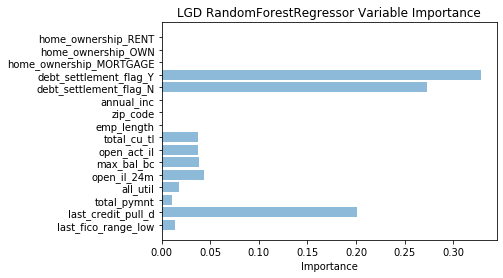

In [ ]:
plt.barh(LGDtest.iloc[:,LGDtest.columns != 'LGD'].columns, \
         LGD_rf.feature_importances_,
        align='center', alpha=0.5)
plt.yticks(LGDtest.iloc[:,LGDtest.columns != 'LGD'].columns)
plt.xlabel('Importance')
plt.title('LGD RandomForestRegressor Variable Importance')
plt.show()

## Build XGBoosting Model for LGD

### Find the optimal parameter for the XG Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid2 = {
    'learning_rate': [0.1, 0.01],
    'n_estimators': [2000, 4000, 8000, 16000],
    'min_samples_leaf': [1, 4, 8, 16],
    'min_samples_split': [2, 4, 8],
    'max_depth': [2,3], 
    'max_features': ['auto', 'sqrt'],
}
# Create a based model
xg = GradientBoostingRegressor()
# Instantiate the grid search model
grid_search2 = GridSearchCV(estimator = xg, param_grid = param_grid2, 
                          cv = 3, n_jobs = -1, verbose = 1)


In [ ]:
grid_search2.fit((sample.iloc[:,sample.columns != 'LGD']), sample['LGD'])

Fitting 3 folds for each of 384 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed: 27.9min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter...
                             

In [ ]:
grid_search2.best_params_

{'learning_rate': 0.01,
 'max_depth': 3,
 'max_features': 'sqrt',
 'min_samples_leaf': 8,
 'min_samples_split': 4,
 'n_estimators': 2000}

### Build LGD Model using XGBoosting Regressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
LGD_xg = GradientBoostingRegressor(loss='ls', #least square 
                           learning_rate=0.01, # How much to shrink error in each subsequent training. 
                           n_estimators=2000, # Use optimal one found above
                           subsample=0.632, # Subsampling to use. 63.2% of data is standard for XGBoost.
                           criterion='friedman_mse', # Error to use for each split. 
                           min_samples_split=4, # Minimum samples for a split.
                           min_samples_leaf=8, # Minimum samples in a leaf.
                           min_weight_fraction_leaf=0.0, # Minimum fraction of samples in a leaf. Consider increasing if first few trees too good.
                           max_depth=3, # Maximum depth. Keep it small!
                           min_impurity_decrease=0.01, # Minimum impurity decrease. Might want to use 1% or so.
                           init=None, # How to make first prediction (it needs one). Can give model that supports fit and predict.
                           random_state=251121253, # Seed
                           max_features='sqrt',
                           verbose=1,  
                           max_leaf_nodes=None,  
                           warm_start=False,  
                           presort='auto', # Whether to presort the data to speed up training.
                           validation_fraction=0.3, 
                           n_iter_no_change=None, # Iters to stop training if no change occurs between one tree and the next.
                           tol=0.0001 # Tolerance. Means maximum change of 10^-4
                          )

In [ ]:
LGD_xg.fit(LGDtrain.iloc[:,LGDtrain.columns != 'LGD'], 
              LGDtrain['LGD'])

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0126           0.0000            1.15m
         2           0.0127           0.0000            1.04m
         3           0.0126           0.0001            1.02m
         4           0.0127           0.0001            1.01m
         5           0.0125           0.0001            1.02m
         6           0.0124           0.0000            1.00m
         7           0.0123           0.0001            1.01m
         8           0.0122           0.0001            1.01m
         9           0.0121           0.0001            1.00m
        10           0.0121           0.0000           59.67s
        20           0.0117           0.0000           58.26s
        30           0.0112           0.0000           58.28s
        40           0.0108           0.0000           57.54s
        50           0.0107           0.0000           56.94s
        60           0.0102           0.0000           56.45s
       

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=3,
                          max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.01, min_impurity_split=None,
                          min_samples_leaf=8, min_samples_split=4,
                          min_weight_fraction_leaf=0.0, n_estimators=2000,
                          n_iter_no_change=None, presort='auto',
                          random_state=251121253, subsample=0.632, tol=0.0001,
                          validation_fraction=0.3, verbose=1, warm_start=False)

In [ ]:
print(LGD_xg.feature_importances_)

[7.45137162e-02 2.76683342e-01 7.27902683e-02 2.60808052e-02
 1.52975877e-02 1.75750630e-02 1.82910411e-02 1.72761651e-02
 1.50421949e-03 2.86388223e-03 7.89348376e-03 2.24075782e-01
 2.44147845e-01 4.08923176e-04 2.58443370e-04 3.39432819e-04]


In [ ]:
R2_xg = LGD_xg.score(LGDtest.iloc[:,LGDtest.columns != 'LGD'], LGDtest['LGD'])

In [ ]:
n = LGDtest.shape[0] 
p = len(LGD_Variables)
Adj_r2_xg = 1-(1-R2_xg)*(n-1)/(n-p-1)
print(R2_xg)
print(Adj_r2_xg)

0.3971963273327419
0.3970315561308726


In [ ]:
mse = mean_squared_error(LGD_xg.predict\
                         (LGDtest.iloc[:,LGDtest.columns != 'LGD']), \
                         LGDtest['LGD'])
mse

0.0075087669822225

### Importance of parameter for XG Boosting 

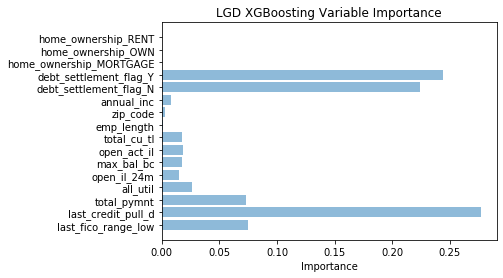

In [ ]:
plt.barh(LGDtest.iloc[:,LGDtest.columns != 'LGD'].columns, \
         LGD_xg.feature_importances_,
        align='center', alpha=0.5)
plt.yticks(LGDtest.iloc[:,LGDtest.columns != 'LGD'].columns)
plt.xlabel('Importance')
plt.title('LGD XGBoosting Variable Importance')
plt.show()

## Apply the regressor on the non-defaulted Loans 

In [ ]:
## Download the pre saved, cleaned data
!gdown https://drive.google.com/uc?id=142LOcmTXygAqkDhA7yuQwaiGIL_UUT1-

Downloading...
From: https://drive.google.com/uc?id=142LOcmTXygAqkDhA7yuQwaiGIL_UUT1-
To: /content/credit_data2.csv
129MB [00:00, 134MB/s]


In [ ]:
Loan_data = pd.read_csv('credit_data2.csv')

In [ ]:
## We just need the non-defaulted ones
Undefaulted = Loan_data.loc[Loan_data['loan_status'] == 0]

In [ ]:
Undefaulted.shape

(367591, 56)

In [ ]:
## Leave only selected variables
Undefaulted = Undefaulted[LGD_Variables]

In [ ]:
Undefaulted = pd.get_dummies(Undefaulted)

In [ ]:
np.any(np.isnan(Undefaulted))

True

In [ ]:
Undefaulted.isnull().sum()

last_fico_range_low        0
last_credit_pull_d         0
total_pymnt                0
all_util                   0
open_il_24m                0
max_bal_bc                 0
open_act_il                0
total_cu_tl                0
LGD                        1
emp_length                 0
zip_code                   0
annual_inc                 0
debt_settlement_flag_N     0
debt_settlement_flag_Y     0
home_ownership_MORTGAGE    0
home_ownership_OWN         0
home_ownership_RENT        0
dtype: int64

In [ ]:
## It seems there is a cell lost during the transmission
## It's OK to drop only one row
Undefaulted = Undefaulted.dropna(axis=0, subset=['LGD'])

In [ ]:
Undefaulted.shape

(367590, 17)

### Estimate the LGD for the non-defaulted class using random forest 

In [ ]:
LGDRF_estimate = LGD_rf.predict(Undefaulted.iloc[:, Undefaulted.columns != 'LGD'])

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    1.5s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    2.3s
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:    3.3s
[Parallel(n_jobs=2)]: Done 2446 tasks      | elapsed:    4.5s
[Parallel(n_jobs=2)]: Done 3196 tasks      | elapsed:    5.9s
[Parallel(n_jobs=2)]: Done 4046 tasks      | elapsed:    7.4s
[Parallel(n_jobs=2)]: Done 4996 tasks      | elapsed:    9.1s
[Parallel(n_jobs=2)]: Done 5000 out of 5000 | elapsed:    9.1s finished


In [ ]:
Average_LGD_rf = LGDRF_estimate.sum() / Undefaulted.shape[0]
print(Average_LGD_rf)

0.9296144607002328


### Estimate the LGD for the non-defaulted class using XGBoosting

In [ ]:
LGDxg_estimate = LGD_xg.predict(Undefaulted.iloc[:, Undefaulted.columns != 'LGD'])

In [ ]:
Average_LGD_xg = LGDxg_estimate.sum() / Undefaulted.shape[0]
print(Average_LGD_xg)

0.9012328189895862
